In [51]:
import sys, os
from pyprojroot import here


# spyder up to find the root
root = here(project_files=[".local"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import xarray as xr
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from tqdm.notebook import tqdm, trange
from kernellib.types import GeoData, Dimensions
from kernellib.kernels import SpatioTemporalKernel
from sklearn.kernel_ridge import KernelRidge

%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [53]:
# OI Grid
lon_min = 295.                                           # domain min longitude
lon_max = 305.                                           # domain max longitude
lat_min = 33.                                            # domain min latitude
lat_max = 43.                                            # domain max latitude
time_min = np.datetime64('2017-01-01')                # domain min time
time_max = np.datetime64('2017-01-31') #np.datetime64('2017-12-31')                # domain max time
dx = 0.2                                               # zonal grid spatial step (in degree)
dy = 0.2                                                 # meridional grid spatial step (in degree)
dt = np.timedelta64(1, 'D')                           # temporal grid step

glon = np.arange(lon_min, lon_max + dx, dx)           # output OI longitude grid
glat = np.arange(lat_min, lat_max + dy, dy)           # output OI latitude grid
gtime = np.arange(time_min, time_max + dt, dt)        # output OI time grid

In [54]:
glon.shape, glat.shape, gtime.shape

((51,), (52,), (31,))

### OI Params

In [55]:
# OI parameters
Lx = 1.                                                  # Zonal decorrelation scale (in degree)
Ly = 1.                                                  # Meridional decorrelation scale (in degree)
Lt = 1.                                                  # Temporal decorrelation scale (in days)
noise = 0.05

## OI Grid

In [56]:
def create_oi_grid(glon, glat, gtime):
    """
    
    """
    

    nx = len(glon)
    ny = len(glat)
    nt = len(gtime)

    # define & initialize ssh array
    gssh_mu = np.empty((nt, ny, nx))
    gssh_var = np.empty((nt, ny, nx))
    nobs = np.empty(nt)

    # Make 2D grid
    glon2, glat2 = np.meshgrid(glon, glat)
    fglon = glon2.flatten()
    fglat = glat2.flatten()

    ng = len(fglat) # number of grid points
    vtime = (gtime - gtime[0]) / np.timedelta64(1, 'D')
    
    
    ds_oi_grid = xr.Dataset({'gssh_mu' : (('time', 'lat', 'lon'), gssh_mu), 
                             'gssh_var' : (('time', 'lat', 'lon'), gssh_var),
                             'glon2' : (('lat', 'lon'), glon2),
                             'glat2' : (('lat', 'lon'), glat2),
                             'fglon' : (('ng'), fglon),
                             'fglat' : (('ng'), fglat),
                             'nobs' : (('time'), nobs)},
                              coords={'gtime': (vtime).astype(np.float),
                                      'time': gtime,
                                      'lat': glat, 
                                      'lon': glon,
                                      'ng': np.arange(ng)})

    return ds_oi_grid

In [57]:
ds_oi_grid = create_oi_grid(glon, glat, gtime)
ds_oi_grid

<xarray.Dataset>
Dimensions:   (time: 31, lat: 52, lon: 51, ng: 2652, gtime: 31)
Coordinates:
  * gtime     (gtime) float64 0.0 1.0 2.0 3.0 4.0 ... 26.0 27.0 28.0 29.0 30.0
  * time      (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-01-31
  * lat       (lat) float64 33.0 33.2 33.4 33.6 33.8 ... 42.6 42.8 43.0 43.2
  * lon       (lon) float64 295.0 295.2 295.4 295.6 ... 304.4 304.6 304.8 305.0
  * ng        (ng) int64 0 1 2 3 4 5 6 7 ... 2645 2646 2647 2648 2649 2650 2651
Data variables:
    gssh_mu   (time, lat, lon) float64 6.936e-310 6.936e-310 ... 7.291e-304
    gssh_var  (time, lat, lon) float64 6.936e-310 0.0 ... 0.0 6.936e-310
    glon2     (lat, lon) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
    glat2     (lat, lon) float64 33.0 33.0 33.0 33.0 ... 43.2 43.2 43.2 43.2
    fglon     (ng) float64 295.0 295.2 295.4 295.6 ... 304.4 304.6 304.8 305.0
    fglat     (ng) float64 33.0 33.0 33.0 33.0 33.0 ... 43.2 43.2 43.2 43.2 43.2
    nobs      (time) float64 8.482e-320 8.482e-320 ... 8.496e-320 8.496e-320

## Observations

In [58]:
file_path = "/Volumes/EMANS_HDD/data/2021a_ose"

inputs = [f'{file_path}/dt_gulfstream_alg_phy_l3_20161201-20180131_285-315_23-53.nc', 
          f'{file_path}/dt_gulfstream_j3_phy_l3_20161201-20180131_285-315_23-53.nc', 
          f'{file_path}/dt_gulfstream_s3a_phy_l3_20161201-20180131_285-315_23-53.nc',
          f'{file_path}/dt_gulfstream_h2g_phy_l3_20161201-20180131_285-315_23-53.nc',
          f'{file_path}/dt_gulfstream_j2g_phy_l3_20161201-20180131_285-315_23-53.nc',
          f'{file_path}/dt_gulfstream_j2n_phy_l3_20161201-20180131_285-315_23-53.nc'] 

In [59]:
import hvplot.xarray

### Convert to Grid

In [60]:
def create_sla_grid(gdata, glon, glat, gtime):
    """
    
    """
    

    nx = len(glon)
    ny = len(glat)
    nt = len(gtime)

    # define & initialize ssh array
    gssh_mu = np.empty((nt, ny, nx))
    gssh_var = np.empty((nt, ny, nx))
    nobs = np.empty(nt)

    # Make 2D grid
    glon2, glat2 = np.meshgrid(glon, glat)
    fglon = glon2.flatten()
    fglat = glat2.flatten()

    ng = len(fglat) # number of grid points
    vtime = (gtime - gtime[0]) / np.timedelta64(1, 'D')
    
    
    ds_oi_grid = xr.Dataset({'gssh_mu' : (('time', 'lat', 'lon'), gssh_mu), 
                             'gssh_var' : (('time', 'lat', 'lon'), gssh_var),
                             'glon2' : (('lat', 'lon'), glon2),
                             'glat2' : (('lat', 'lon'), glat2),
                             'fglon' : (('ng'), fglon),
                             'fglat' : (('ng'), fglat),
                             'nobs' : (('time'), nobs)},
                              coords={'gtime': (vtime).astype(np.float),
                                      'time': gtime,
                                      'lat': glat, 
                                      'lon': glon,
                                      'ng': np.arange(ng)})

    return ds_oi_grid

In [61]:
ds = xr.open_dataset(inputs[0])
ds

<xarray.Dataset>
Dimensions:         (time: 404083)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-01T08:49:09.733021952 ... 2...
    longitude       (time) float64 ...
    latitude        (time) float64 ...
Data variables:
    cycle           (time) float64 ...
    track           (time) float64 ...
    dac             (time) float32 ...
    lwe             (time) float32 ...
    mdt             (time) float32 ...
    ocean_tide      (time) float64 ...
    sla_filtered    (time) float32 ...
    sla_unfiltered  (time) float32 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [62]:
central_date = np.datetime64('2017-01-15')
delta_t = np.timedelta64(5, 'D')

In [63]:
coarsening = {'time': 5}

In [64]:
def preprocess(ds):
    return ds.coarsen(coarsening, boundary="trim").mean()

ds_obs = xr.open_mfdataset(inputs, combine='nested', concat_dim='time', parallel=True, preprocess=preprocess) #.sortby('time')
#ds_obs = ds_obs.coarsen(coarsening, boundary="trim").mean().sortby('time')
ds_obs = ds_obs.sortby('time')

/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 3806 times more chunks
  return self.array[key]
/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 3806 times more chunks
  return self.array[key]
/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 3806 times more chunks
  return self.array[key]
/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 3806 times more chunks
  return self.array[key]
/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is

In [65]:
# correct lon if domain is between [-180:180]
if lon_min < 0:
    ds_obs['longitude'] = xr.where(ds_obs['longitude'] >= 180., ds_obs['longitude']-360., ds_obs['longitude'])

In [66]:
# get maximum coordinate values
lon_min = ds_oi_grid.lon.min().values
lon_max = ds_oi_grid.lon.max().values
lat_min = ds_oi_grid.lat.min().values
lat_max = ds_oi_grid.lat.max().values
time_min = ds_oi_grid.time.min().values
time_max = ds_oi_grid.time.max().values

    

In [67]:
# subset time
ds_obs_subset = ds_obs.sel(time=slice(time_min - np.timedelta64(int(2*Lt), 'D'), 
                               time_max + np.timedelta64(int(2*Lt), 'D')), drop=True)

In [68]:
ds_obs_subset

<xarray.Dataset>
Dimensions:         (time: 32739)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-30T00:21:51.373161011 ... 2...
    longitude       (time) float64 dask.array<chunksize=(19,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(19,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(19,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(19,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(19,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(19,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(19,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(19,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(19,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(19,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [69]:
# subset lat/lon values
ds_obs_subset = ds_obs_subset.where(
    (ds_obs_subset['longitude'] >= lon_min - Lx) & 
    (ds_obs_subset['longitude'] <= lon_max + Lx) &
    (ds_obs_subset['latitude'] >= lat_min - Ly) &
    (ds_obs_subset['latitude'] <= lat_max + Ly),
    drop=True
)

In [70]:
ds_obs_subset

<xarray.Dataset>
Dimensions:         (time: 6589)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-30T01:58:22.595521126 ... 2...
    longitude       (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [71]:
def add_vtime(ds, time_min: np.datetime64):
    vtime = (ds['time'].values - time_min) / np.timedelta64(1, 'D')
    return ds.assign_coords({'time': vtime})

In [72]:
type(time_min)

numpy.datetime64

In [73]:
time_min = np.datetime64('2017-01-01')
ds_obs_subset = add_vtime(ds_obs_subset, time_min)

In [74]:
# # add vtime coord
# vtime = (ds_obs_subset['time'].values - time_min) / np.timedelta64(1, 'D')
# ds_obs_subset = ds_obs_subset.assign_coords({'time': vtime})



In [75]:
ds_obs_subset = ds_obs_subset.dropna(dim='time')

In [76]:
ds_obs_subset

<xarray.Dataset>
Dimensions:         (time: 6589)
Coordinates:
  * time            (time) float64 -1.918 -1.918 -1.918 ... 31.99 31.99 31.99
    longitude       (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

## OI Algorithm

$$
\mathbf{y} = \mathbf{Hx} + \boldsymbol{\epsilon}
$$

where:

* $\mathbf{x} \in \mathbb{R}^{D_\mathbf{x}}$ - the unknown state to be estimated
* $\mathbf{y} \in \mathbb{R}^{D_\mathbf{y}}$ - the observations
* $\mathbf{H} \in \mathbb{R}^{D_\mathbf{y} \times D_\mathbf{x}}$ - the linear observation operator
* $\boldsymbol{\epsilon} \in \mathbb{R}^{D_\mathbf{y}}$ - the independent observation error

---

$$
\mathbf{x} = \mathbf{Ky}
$$

where:

* $\mathbf{K} \in \mathbb{R}^{D_\mathbf{x} \times D_\mathbf{y}}$ - Kalman Gain

$$
\mathbf{K} = \mathbf{BH}^\top \left( \mathbf{HBH}^\top\right)^{-1}
$$

where:

* $\mathbf{B} \in \mathbb{R}^{D_\mathbf{x} \times D_\mathbf{x}}$ - covariance of $\mathbf{x}$


### Example I - Single Region

In [77]:
# example time step
i_time = 10

In [78]:
# get indices where there are observations
ind1 = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 2. * Lt))[0]

ind_t = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 0.5))[0]
n_obs = len(ind1)


# get observation data
obs_data = GeoData(
    lat=ds_obs_subset.latitude.values[ind1],
    lon=ds_obs_subset.longitude.values[ind1],
    time=ds_obs_subset.time.values[ind1],
    data=ds_obs_subset.sla_unfiltered.values[ind1]
)

obs_data_t = GeoData(
    lat=ds_obs_subset.latitude.values[ind_t],
    lon=ds_obs_subset.longitude.values[ind_t],
    time=ds_obs_subset.time.values[ind_t],
    data=ds_obs_subset.sla_unfiltered.values[ind_t]
)

# get state data
state_data = Dimensions(
    lat=ds_oi_grid.fglat.values,
    lon=ds_oi_grid.fglon.values,
    time=ds_oi_grid.gtime.values[i_time]
)


state_coords = state_data.coord_vector()
obs_coords = obs_data.coord_vector()

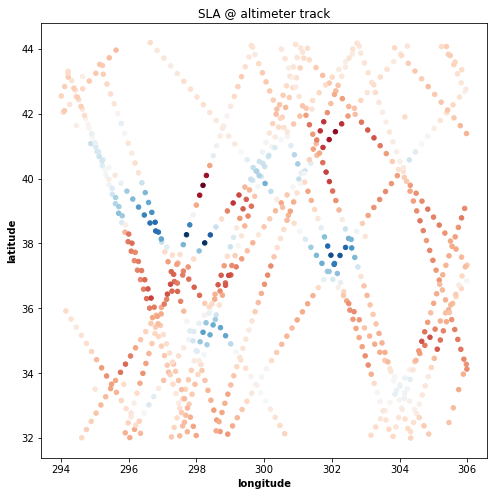

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(obs_data.lon, obs_data.lat, c=obs_data.data, s=20, cmap='RdBu_r')
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
plt.title(f'SLA @ altimeter track')
# plt.colorbar(orientation='horizontal')
plt.show()

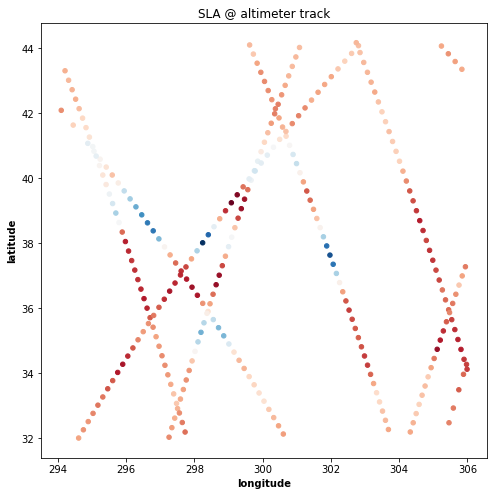

In [80]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r')
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
plt.title(f'SLA @ altimeter track')
# plt.colorbar(orientation='horizontal')
plt.show()

In [81]:
print(state_coords.shape, obs_coords.shape)

(2652, 3) (788, 3)


#### Data Kernel Matrix


$$
\boldsymbol{k}([\mathbf{x},t], [\mathbf{x}', t']) = \boldsymbol{k}(\mathbf{x},\mathbf{x}') * \boldsymbol{k}(t, t')
$$

where: $\mathbf{x} = \text{lat, lon}$


$$
\boldsymbol{k}(\mathbf{x},\mathbf{x}') = \exp (-\frac{1}{\sigma^2} ||\mathbf{x} - \mathbf{x}'||_2^2)
$$

In [82]:
from sklearn.gaussian_process.kernels import RBF
from kernellib.kernels import SpatioTemporalKernel

# spatial kernel
length_scale = Lx
length_scale_bounds = (1e-5, 1e5)

spatial_kernel = RBF(
    length_scale=length_scale, 
    length_scale_bounds=length_scale_bounds
)


# temporal kernel
length_scale = Lt
length_scale_bounds = (1e-5, 1e5)

temporal_kernel = RBF(
    length_scale=length_scale, 
    length_scale_bounds=length_scale_bounds
)

kernel = SpatioTemporalKernel(spatial_kernel, temporal_kernel)

In [83]:
K = kernel(obs_coords)

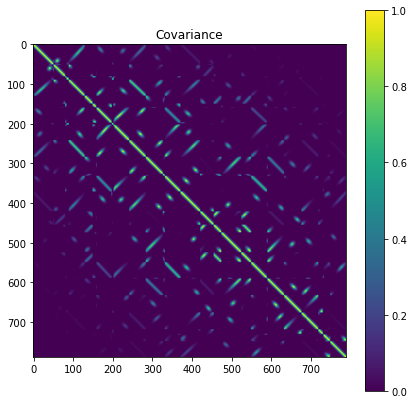

In [84]:
fig, ax = plt.subplots(figsize=(7, 7))

img = ax.imshow(K, cmap="viridis")
ax.set(title="Covariance")
plt.colorbar(img)
plt.show()

#### Weights

**Solving**

$$
\boldsymbol{\alpha} = (\mathbf{K_{XX}} + \sigma^2 \mathbf{I})^{-1} \mathbf{y}
$$

We can use the cholesky decomposition.

$$
\begin{aligned}
\mathbf{L} &= \text{cholesky}(\mathbf{K_{XX}} + \sigma^2 \mathbf{I}) \\
\mathbf{L} \boldsymbol{\alpha} &= \mathbf{y}
\end{aligned}
$$

In [85]:
from kernellib.utils import cholesky_solve
from kernellib.krr import KRR

In [86]:
from sklearn.linear_model._ridge import _solve_cholesky_kernel
from scipy.linalg import solve_triangular
from sklearn.base import BaseEstimator, RegressorMixin

In [87]:
# class KRR(RegressorMixin, BaseEstimator):
#     def __init__(self, alpha=0.1, kernel=None):
#         self.alpha = alpha
#         self.kernel = kernel
        
    
#     def fit(self, X, y):
        
#         # create kernel matrix (data)
#         K = self.kernel(X)
        
#         # add the noise to diagonal elements
#         np.fill_diagonal(K, K.diagonal() + alpha)
        
#         # find the weights, alpha = (K + noise)^-1 y
#         weights, L = cholesky_solve(K, y)
        
#         self.weights_ = weights
#         self.L_ = L
#         self.X_fit_ = X
        
#         return self
    
#     def predict(self, X, return_var: bool=False, return_cov: bool=False):
#         # TODO include noise
        
#         # make predictions
#         K_trans = self.kernel(X, self.X_fit_)

#         # predictive mean
#         y_pred = np.dot(K_trans, weights)


#         if return_var:
#             # TODO Fix this to the kernel

#             # diagonal elements
#             y_var = np.ones(K_trans.shape[0])

#             # solve
#             v = solve_triangular(self.L_[0], K_trans.T, lower=True)
#             y_var = y_var + np.einsum("ij,ji->i", v.T, v)

#             return y_pred, y_var

#         elif return_cov:

#             K_star = self.kernel(X, X)
#             v = solve_triangular(self.L_[0], K_trans.T, lower=True)
#             y_cov = K_star - v.T @ v

#             return y_pred, y_cov
#         else:

#             return y_pred
    
#     def sample(self, X: np.ndarray=None, n_samples: int=1, seed: int=123):
        
#         rng = np.random.RandomState(seed)
        
#         # predictions
#         if X is None:
#             X = self.X_fit_
        
#         # make predictions (mean, cov)
#         y_mu, y_cov = self.predict(X=X, return_cov=True)
        
#         # sample from a Gaussian distribution
#         y_samples = rng.multivariate_normal(y_mu.squeeze(), y_cov, n_samples).T
        
#         return y_samples


In [88]:
# noise (regularization) model
alpha = noise ** 2

# kernel matrix


# create model
krr_model = KRR(alpha=alpha, kernel=kernel)

In [89]:
# training data
y = obs_data.data[:, None]
x = obs_coords

# fit model
krr_model.fit(x, y)

KRR(alpha=0.0025000000000000005,
    kernel=RBF(length_scale=1) * RBF(length_scale=1))

In [90]:
%%time

y_mu, y_var = krr_model.predict(state_coords, return_var=True)
_, y_cov = krr_model.predict(state_coords, return_cov=True)

y_std = np.sqrt(y_var)

CPU times: user 1.22 s, sys: 225 ms, total: 1.45 s
Wall time: 347 ms


In [91]:
vmin = y_mu.min()
vmax = y_mu.max()
buffer = 1.5

$$
\begin{aligned}
\boldsymbol{m}(\mathbf{x}^*) &= \boldsymbol{k}_{\mathbf{x}}(\mathbf{x}^*) \boldsymbol{\alpha} \\
\boldsymbol{\sigma}^2(\mathbf{x}^*) &= \boldsymbol{k}(\mathbf{x}^*, \mathbf{x'}^*) - \boldsymbol{k}_{\mathbf{x}}(\mathbf{x}^*)(\mathbf{K_{XX}} + \sigma^2 \mathbf{I})^{-1} \boldsymbol{k}_{\mathbf{x}}(\mathbf{x}^*)^\top
\end{aligned}
$$

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:6: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


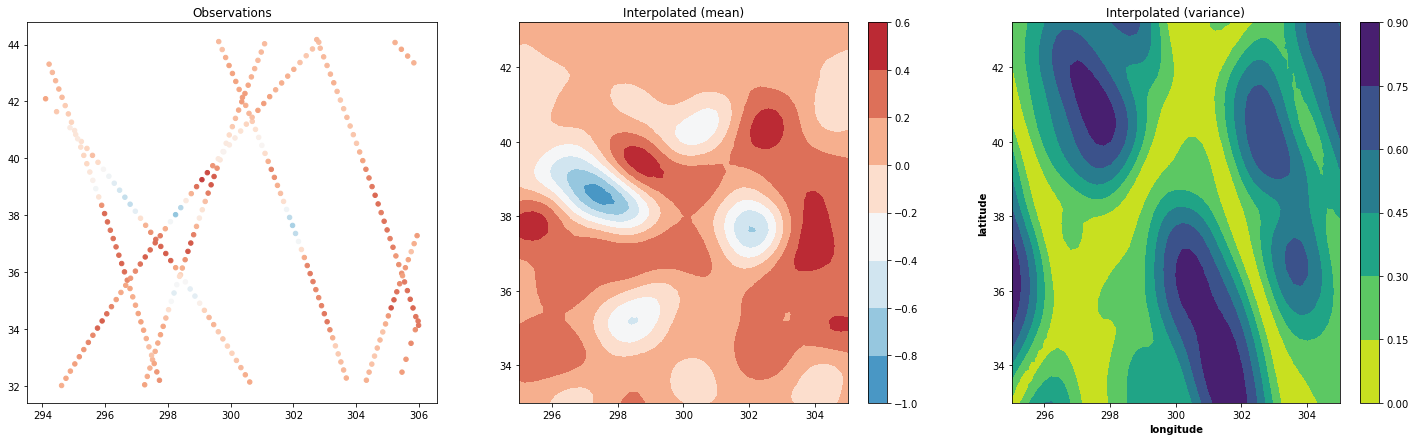

In [92]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)

img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


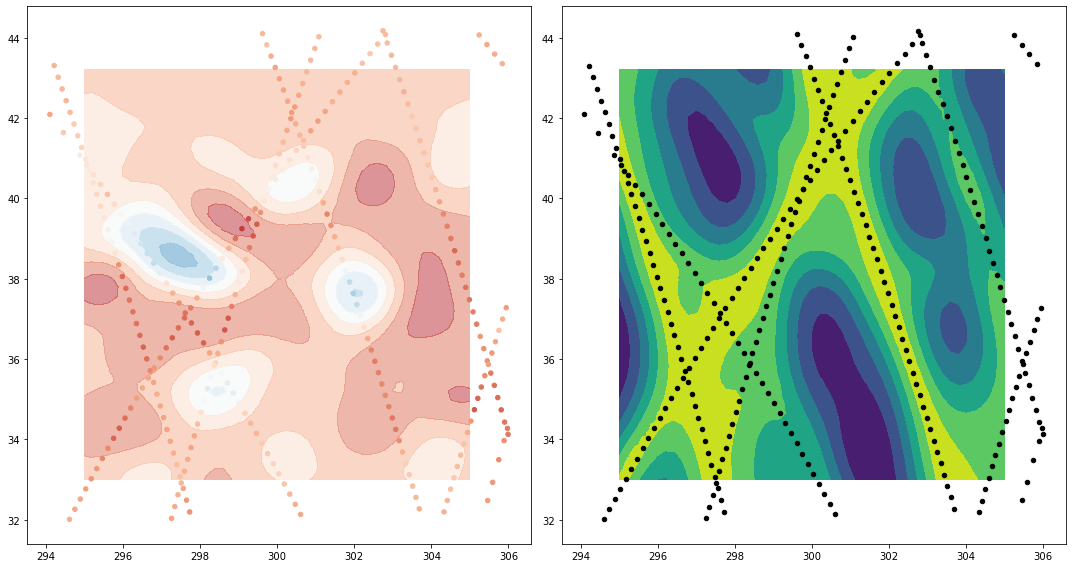

In [93]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

#### Samples

We can calculate the conditional GP posterior from the above mean and covariance equations. Then we can sample from a Normal distribution


$$
\mathbf{x}' \sim \mathcal{N}(\mathbf{x}^* | \boldsymbol{m}(\mathbf{x}^*), \boldsymbol{\Sigma}(\mathbf{x}^*, \mathbf{x'}^*)
$$

In [94]:
%%time

nrows = 10
ncols = 10
n_samples = nrows * ncols

# random state
rng = np.random.RandomState(123)

y_samples = krr_model.sample(state_coords, n_samples=n_samples)


CPU times: user 1min 29s, sys: 10.9 s, total: 1min 40s
Wall time: 39.3 s


In [95]:
y_mu, y_std = y_samples.mean(axis=1), y_samples.std(axis=1)

In [96]:
# vmin = y_mu.min()
# vmax = y_mu.max()
# buffer = 1.5

#### Mean

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:6: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


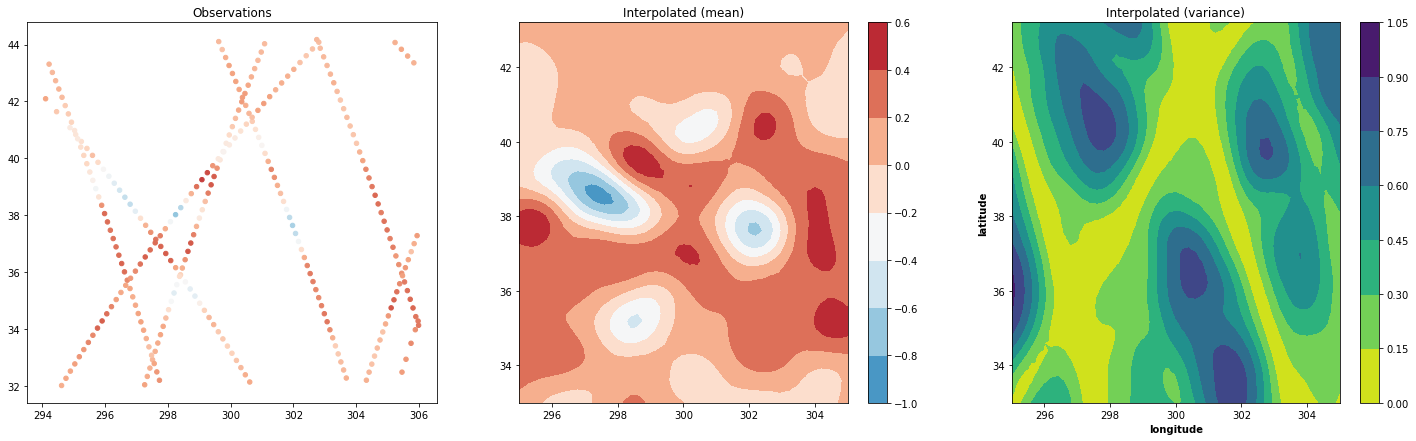

In [97]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)

img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


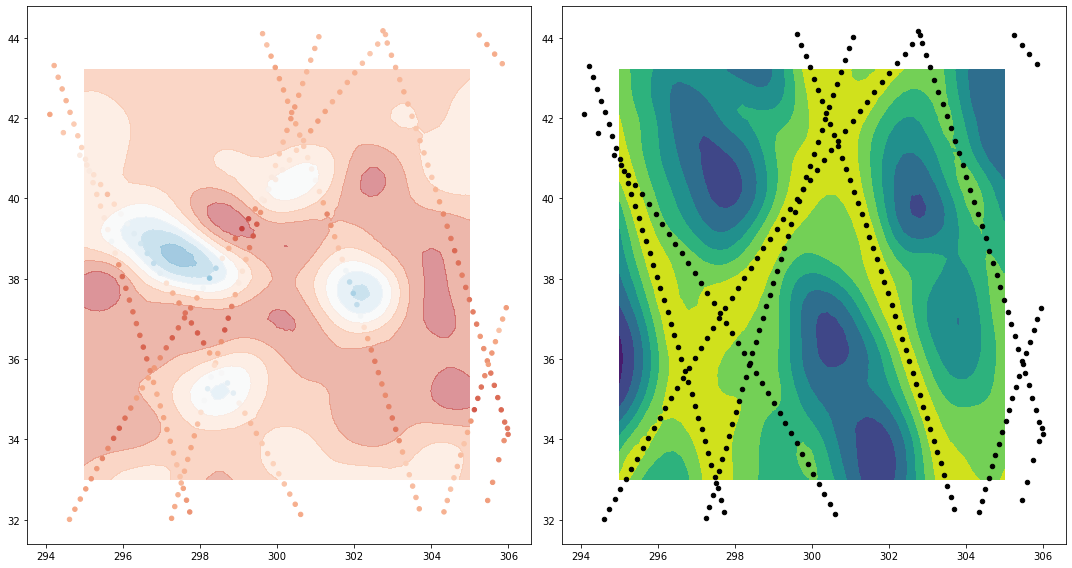

In [98]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

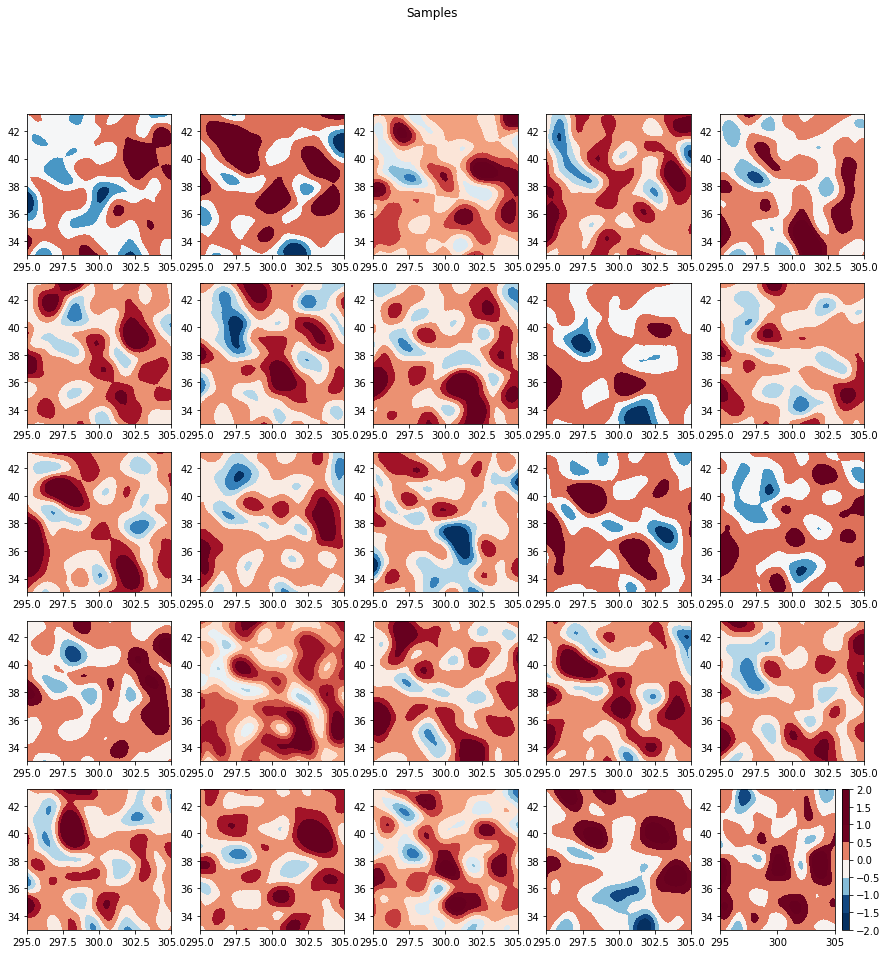

In [99]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    img = iax.tricontourf(state_data.lon, state_data.lat, y_samples[:, i].squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Samples")
plt.colorbar(img)
plt.show()

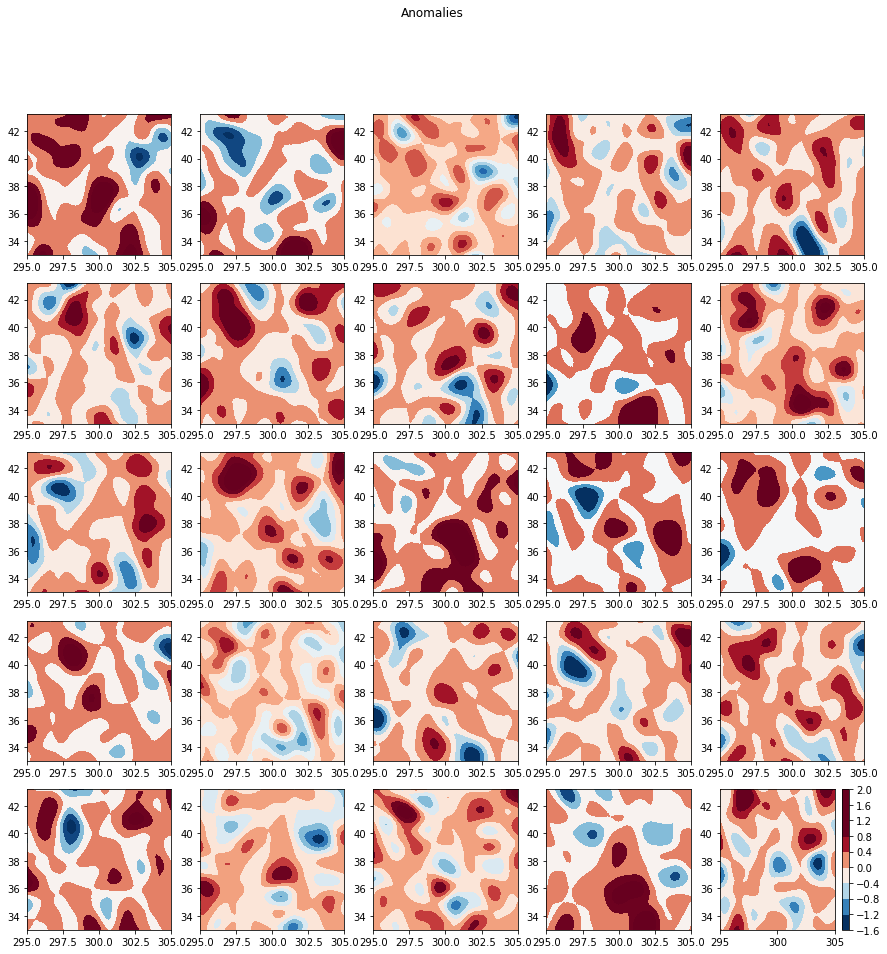

In [100]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    # anomalies
    anomaly = y_mu.squeeze() - y_samples[:, i].squeeze()
    img = iax.tricontourf(state_data.lon, state_data.lat, anomaly.squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Anomalies")
plt.colorbar(img)
plt.show()

In [101]:

for i_time in trange(len(gtime)):
    
    # get indices where there are observations
    ind1 = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 2. * Lt))[0]
    
    ind_t = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 1.))[0]
    n_obs = len(ind1)
    
    # # initialize matrices
    # # (D_x x D_y)
    # BHt = np.empty((len(ds_oi_grid.ng), n_obs))
    # # (D_y x D_y)
    # HBHt = np.empty((n_obs, n_obs))
    
    
    # get observation data
    obs_data = GeoData(
        lat=ds_obs_subset.latitude.values[ind1],
        lon=ds_obs_subset.longitude.values[ind1],
        time=ds_obs_subset.time.values[ind1],
        data=ds_obs_subset.sla_unfiltered.values[ind1]
    )

    obs_data_t = GeoData(
        lat=ds_obs_subset.latitude.values[ind_t],
        lon=ds_obs_subset.longitude.values[ind_t],
        time=ds_obs_subset.time.values[ind_t],
        data=ds_obs_subset.sla_unfiltered.values[ind_t]
    )
    
    # get state data
    state_data = Dimensions(
        lat=ds_oi_grid.fglat.values,
        lon=ds_oi_grid.fglon.values,
        time=ds_oi_grid.gtime.values[i_time]
    )
    
    
    # DATA KERNEL
    
    state_coords = state_data.coord_vector()
    obs_coords = obs_data.coord_vector()
    
    
    krr_model.fit(obs_coords, obs_data.data)
    
    # CROSS KERNEL
    
    y_mu, y_var = krr_model.predict(state_coords, return_var=True)
    
    
    # save into data arrays
    ds_oi_grid.gssh_mu[i_time, :, :] = y_mu.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid.gssh_var[i_time, :, :] = y_var.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid.nobs[i_time] = n_obs

print("Done!")

  0%|          | 0/31 [00:00<?, ?it/s]

Done!


In [102]:
krr_model.kernel

RBF(length_scale=1) * RBF(length_scale=1)

In [103]:
ds_oi_grid.gssh_mu.hvplot.image(width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_mu)

In [104]:
ds_oi_grid.gssh_var.hvplot.image(width=500, height=400, cmap="viridis_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_var)

### Trained

In [105]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.stats.distributions import uniform

param_distributions = {
    "alpha": loguniform(1e-3, 1e1),
    "kernel__k1__length_scale": loguniform(0.1, 100.0),
    "kernel__k2__length_scale": loguniform(1.0, 100.0),
}
kernel_ridge_tuned = RandomizedSearchCV(
    krr_model,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
    verbose=1
)

kernel_ridge_tuned.fit(obs_coords, obs_data.data)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
CPU times: user 2min 17s, sys: 37.4 s, total: 2min 54s
Wall time: 25.8 s


RandomizedSearchCV(estimator=KRR(alpha=0.0025000000000000005,
                                 kernel=RBF(length_scale=1) * RBF(length_scale=1)),
                   n_iter=500,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x188eef700>,
                                        'kernel__k1__length_scale': <scipy.stats._distn_infrastructure.rv_frozen object at 0x18a360d00>,
                                        'kernel__k2__length_scale': <scipy.stats._distn_infrastructure.rv_frozen object at 0x188eef5b0>},
                   random_state=0, verbose=1)

In [106]:
kernel_ridge_tuned.best_params_

{'alpha': 0.2264427601216974,
 'kernel__k1__length_scale': 77.32340308192192,
 'kernel__k2__length_scale': 1.0807950494367506}

In [107]:
krr_model_trained = kernel_ridge_tuned.best_estimator_
krr_model_trained

KRR(alpha=0.2264427601216974,
    kernel=RBF(length_scale=77.3) * RBF(length_scale=1.08))

In [108]:
%%time

y_mu, y_var = krr_model_trained.predict(state_coords, return_var=True)

y_std = np.sqrt(y_var)

CPU times: user 253 ms, sys: 44.6 ms, total: 297 ms
Wall time: 45.1 ms


In [109]:
vmin = y_mu.min()
vmax = y_mu.max()
buffer = 1.5

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:6: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


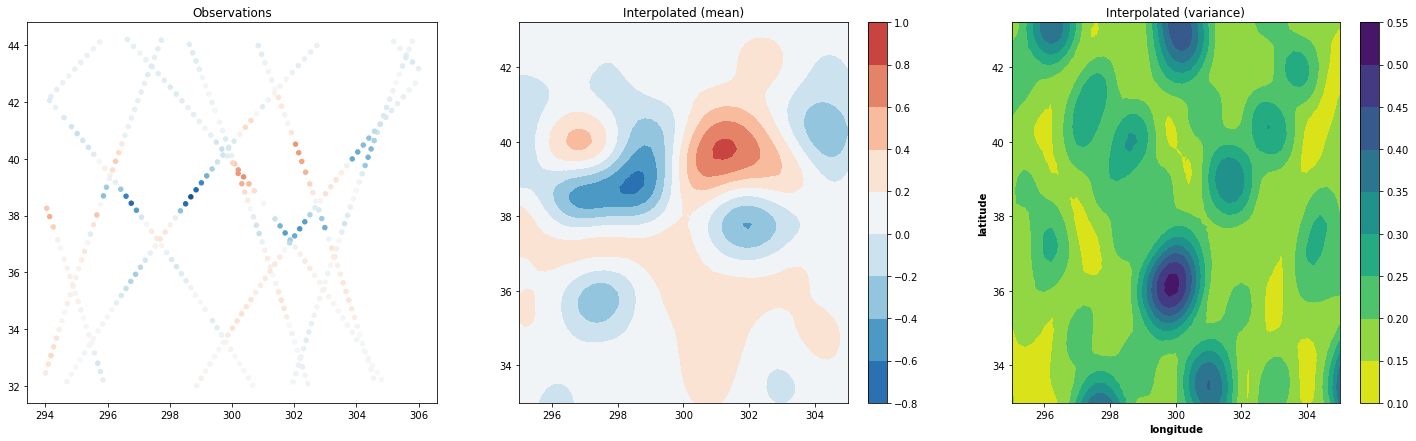

In [110]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)

img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3987732143.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3987732143.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


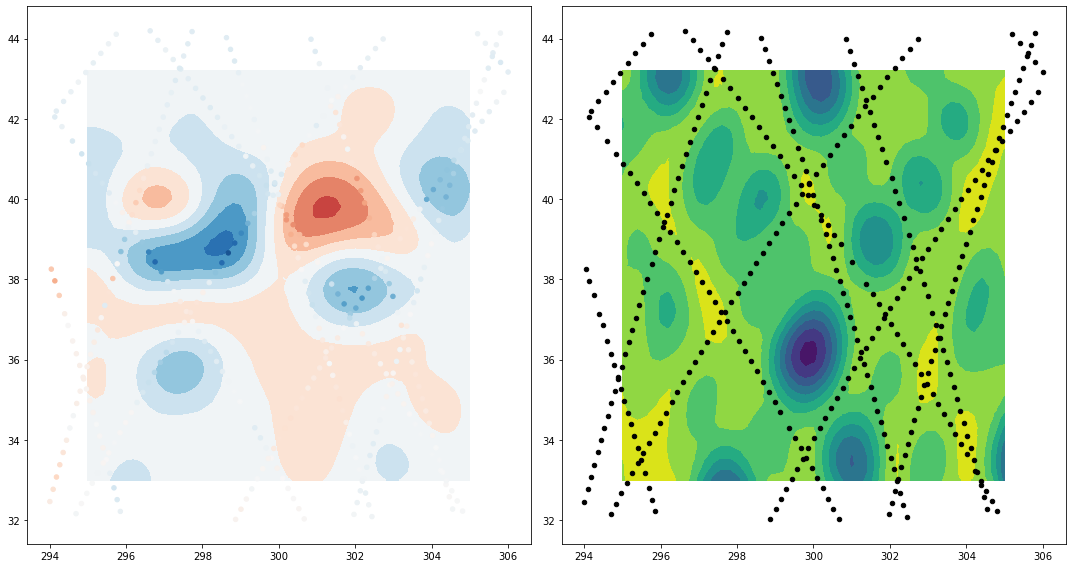

In [111]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

#### Samples

In [112]:
%%time

nrows = 10
ncols = 10
n_samples = nrows * ncols

# random state
rng = np.random.RandomState(123)

y_samples = krr_model_trained.sample(state_coords, n_samples=n_samples)

CPU times: user 50.8 s, sys: 9.27 s, total: 1min
Wall time: 8.79 s


In [113]:
y_mu, y_std = y_samples.mean(axis=1), y_samples.std(axis=1)

##### Mean

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:6: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


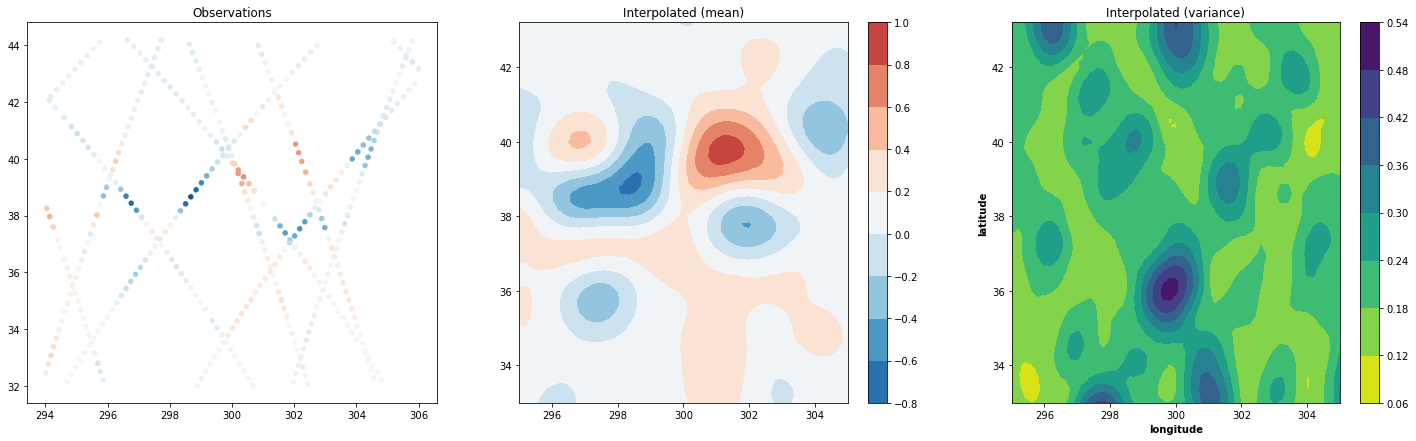

In [114]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)

img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3987732143.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3987732143.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


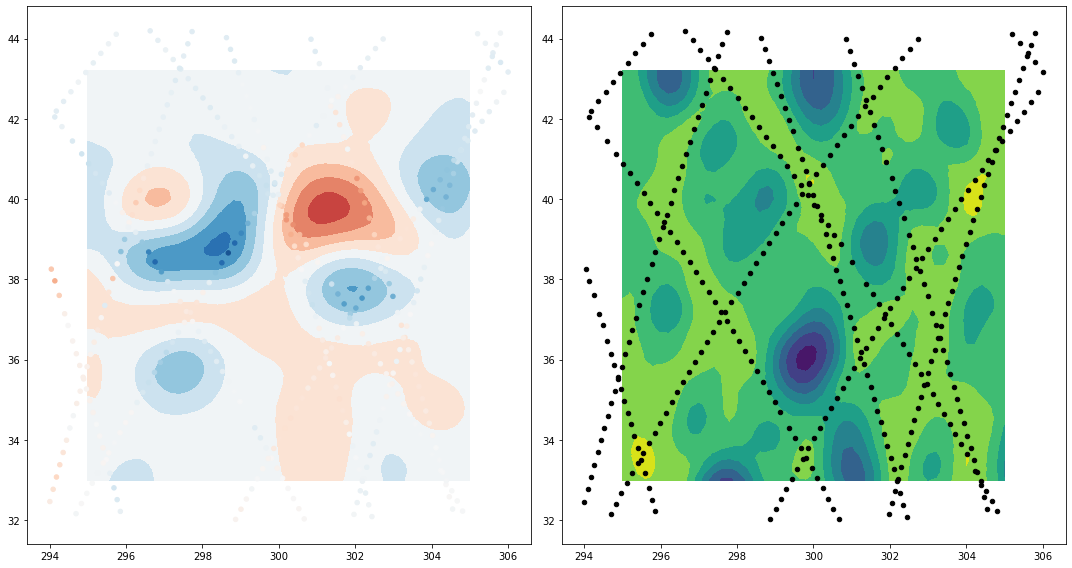

In [115]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

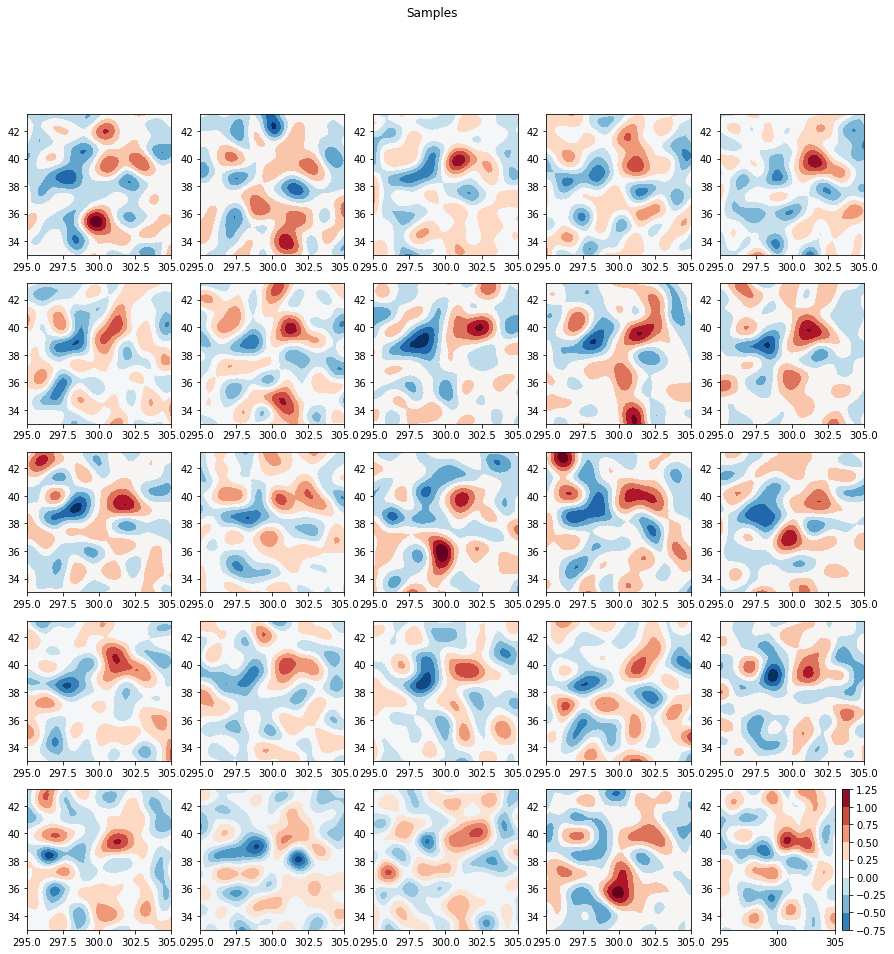

In [116]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    img = iax.tricontourf(state_data.lon, state_data.lat, y_samples[:, i].squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Samples")
plt.colorbar(img)
plt.show()

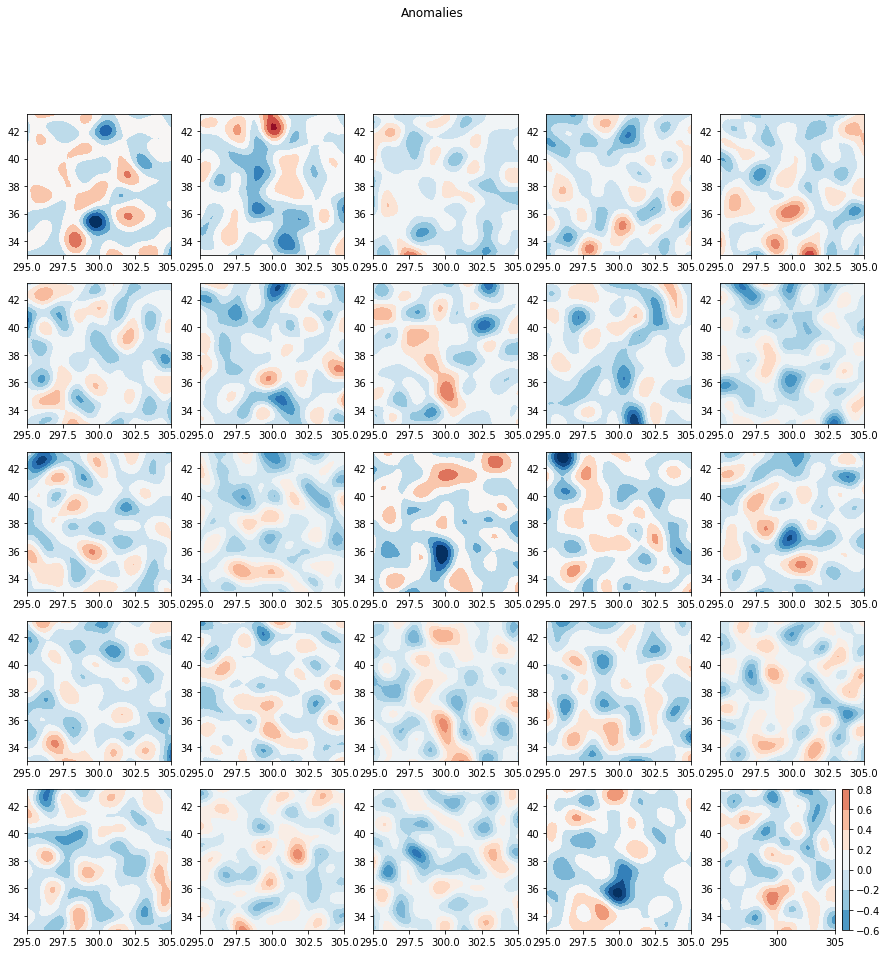

In [117]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    # anomalies
    anomaly = y_mu.squeeze() - y_samples[:, i].squeeze()
    img = iax.tricontourf(state_data.lon, state_data.lat, anomaly.squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Anomalies")
plt.colorbar(img)
plt.show()

In [118]:
ds_oi_grid_trained = ds_oi_grid.copy()

In [119]:

for i_time in trange(len(gtime)):
    
    # get indices where there are observations
    ind1 = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 2. * Lt))[0]
    
    ind_t = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 1.))[0]
    n_obs = len(ind1)
    
    # # initialize matrices
    # # (D_x x D_y)
    # BHt = np.empty((len(ds_oi_grid.ng), n_obs))
    # # (D_y x D_y)
    # HBHt = np.empty((n_obs, n_obs))
    
    
    # get observation data
    obs_data = GeoData(
        lat=ds_obs_subset.latitude.values[ind1],
        lon=ds_obs_subset.longitude.values[ind1],
        time=ds_obs_subset.time.values[ind1],
        data=ds_obs_subset.sla_unfiltered.values[ind1]
    )

    obs_data_t = GeoData(
        lat=ds_obs_subset.latitude.values[ind_t],
        lon=ds_obs_subset.longitude.values[ind_t],
        time=ds_obs_subset.time.values[ind_t],
        data=ds_obs_subset.sla_unfiltered.values[ind_t]
    )
    
    # get state data
    state_data = Dimensions(
        lat=ds_oi_grid.fglat.values,
        lon=ds_oi_grid.fglon.values,
        time=ds_oi_grid.gtime.values[i_time]
    )
    
    
    # DATA KERNEL
    
    state_coords = state_data.coord_vector()
    obs_coords = obs_data.coord_vector()
    
    
    krr_model_trained.fit(obs_coords, obs_data.data)
    
    # CROSS KERNEL
    
    y_mu, y_var = krr_model_trained.predict(state_coords, return_var=True)
    
    
    # save into data arrays
    ds_oi_grid_trained.gssh_mu[i_time, :, :] = y_mu.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid_trained.gssh_var[i_time, :, :] = y_var.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid_trained.nobs[i_time] = n_obs

print("Done!")

  0%|          | 0/31 [00:00<?, ?it/s]

Done!


In [120]:
ds_oi_grid_trained.gssh_mu.hvplot.image(width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_mu)

In [121]:
ds_oi_grid_trained.gssh_var.hvplot.image(width=500, height=400, cmap="viridis_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_var)